<a href="https://www.kaggle.com/code/taha3012000/bone-fracture-detection?scriptVersionId=255118360" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Import required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
import yaml
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import shutil
import cv2
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "iframe_connected"
import matplotlib.patches as patches
import random
from collections import Counter

2025-08-09 11:28:50.997444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754738931.363652      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754738931.462369      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

load data

In [3]:
train_path='/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/'
val_path='/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/'
test_path='/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/'

In [4]:
image_size=(124,124)
batch_size=16
random_seed=42
train_dataset=image_dataset_from_directory(train_path,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           validation_split=0.2,
                                           subset="training",
                                           shuffle=True,
                                           seed=random_seed)

val_dataset=image_dataset_from_directory(val_path,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           validation_split=0.2,
                                           subset="validation",
                                           shuffle=True,
                                           seed=random_seed)

test_dataset=image_dataset_from_directory(test_path,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           shuffle=True,
                                           seed=random_seed)

Found 3631 files belonging to 2 classes.
Using 2905 files for training.


2025-08-09 11:31:22.999389: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 348 files belonging to 2 classes.
Using 69 files for validation.
Found 169 files belonging to 2 classes.


In [5]:
train_dataset.class_names

['images', 'labels']

EDA

In [6]:
fig = make_subplots(rows=3, cols=3, subplot_titles=[f"Image {i+1}" for i in range(9)])
for images, labels in train_dataset.take(1):
    for i in range(9):
        row = i // 3 + 1
        col = i % 3 + 1
        img = images[i].numpy().astype("uint8")

        fig.add_trace(
            go.Image(z=img),
            row=row,
            col=col
        )

fig.update_layout(height=1200, width=1000, showlegend=False)
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)

fig.show()

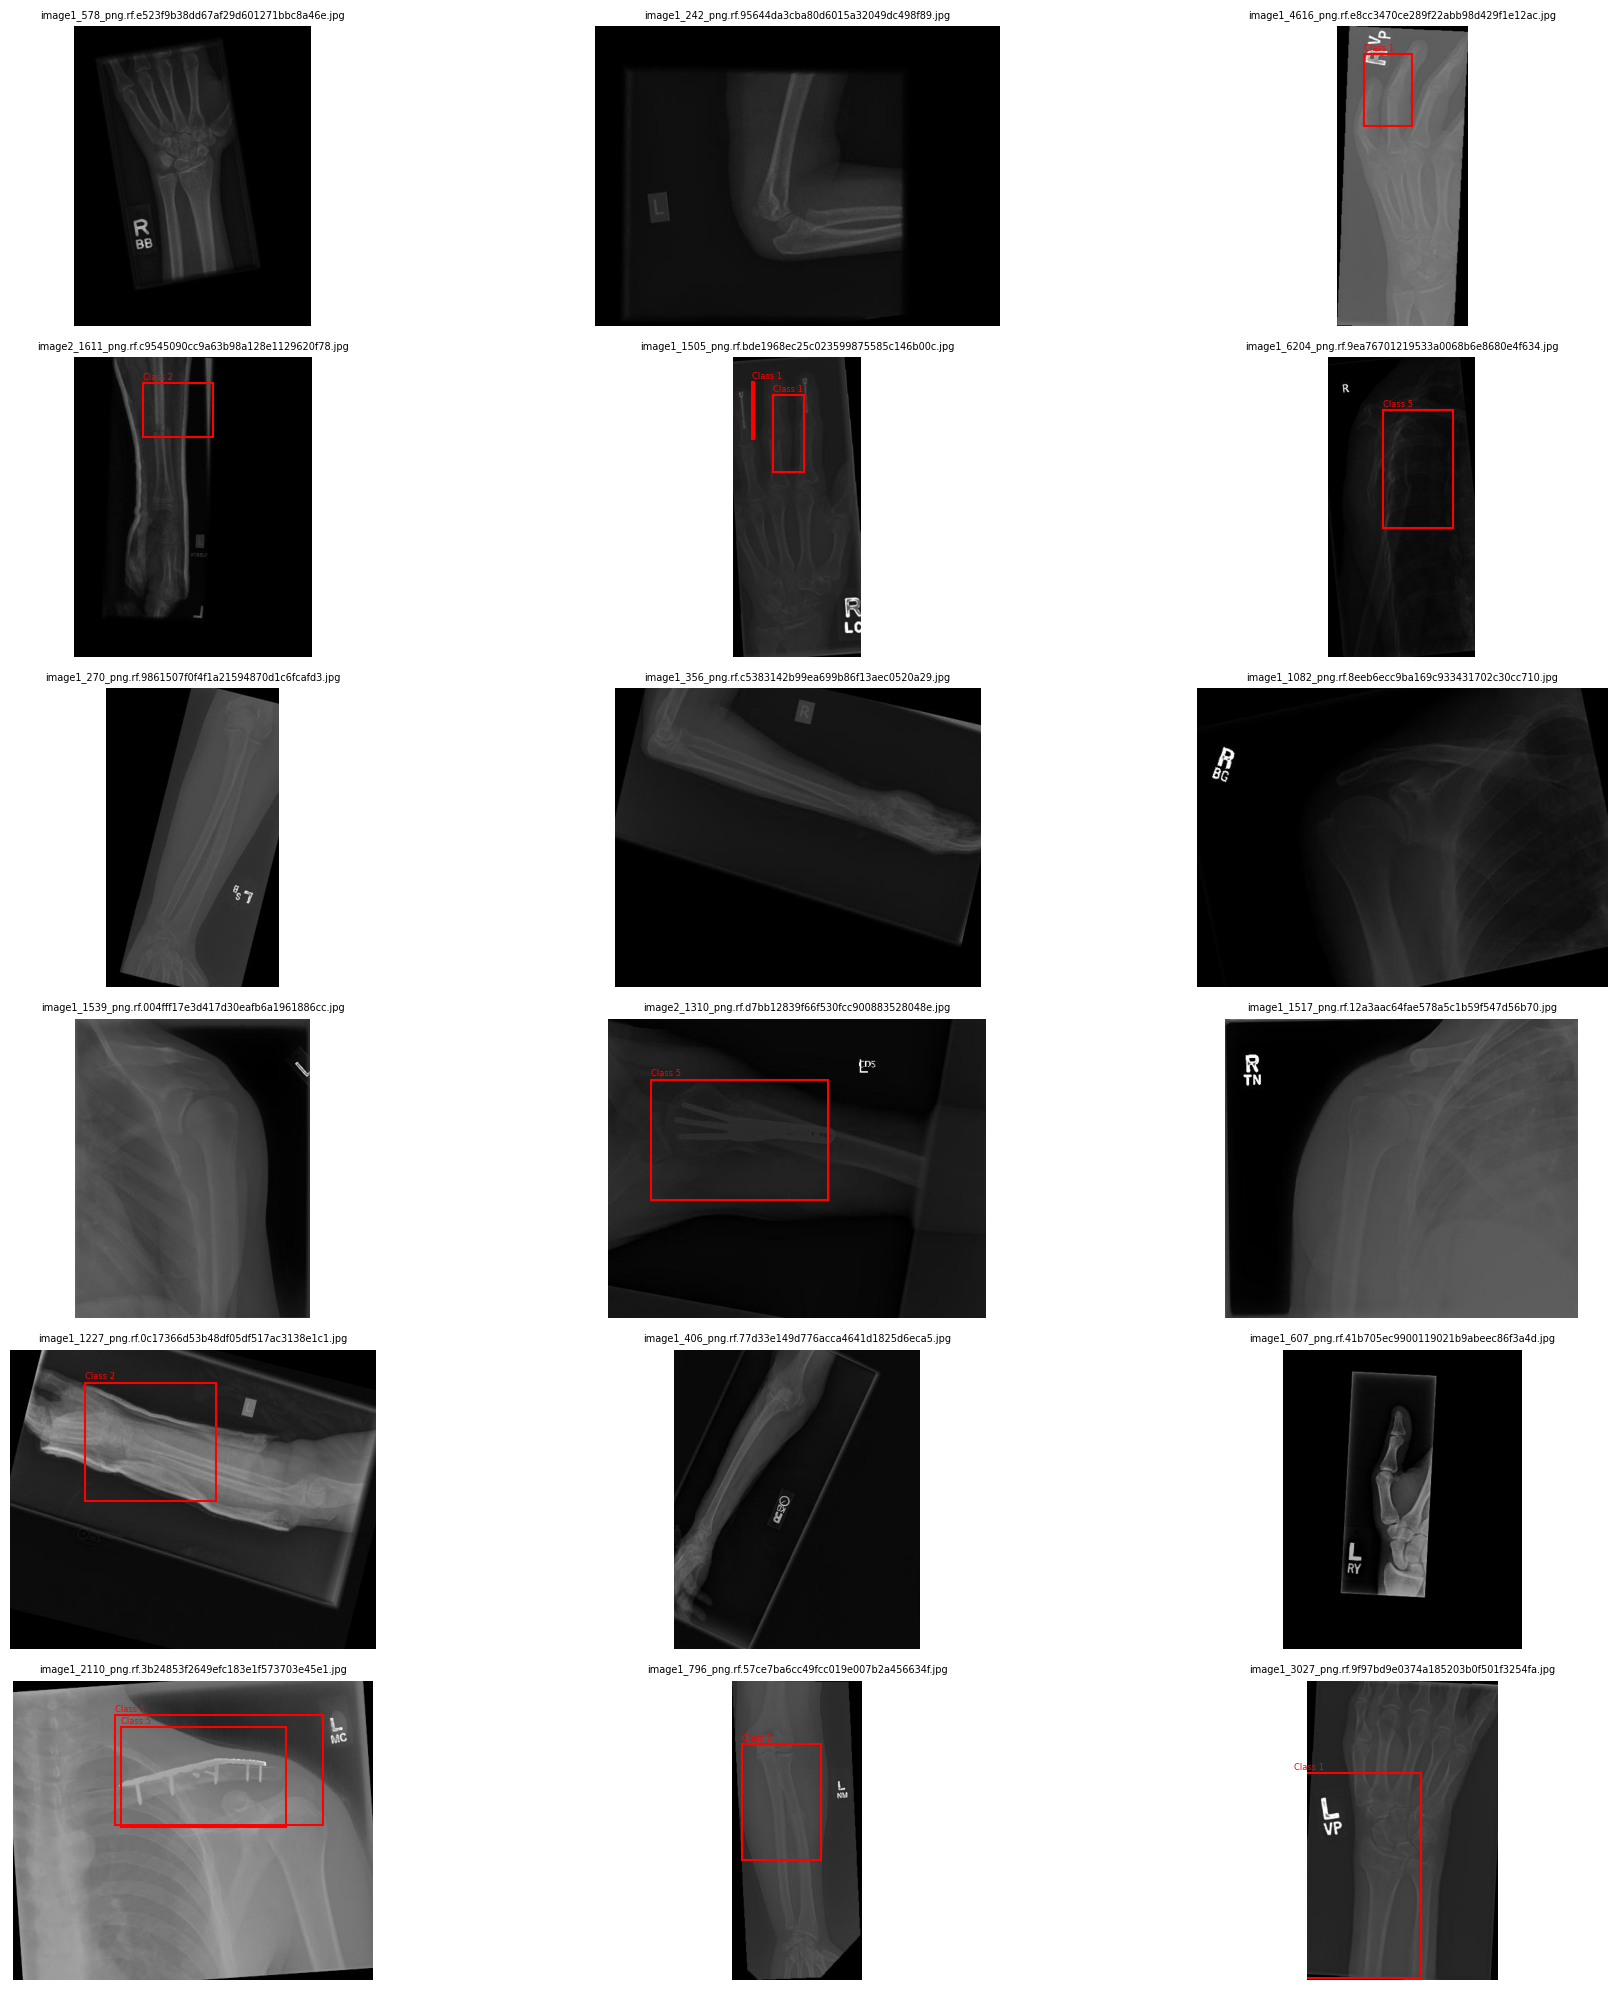

In [7]:
base_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project"
dataset_dir = "bone fracture detection.v4-v4.yolov8"

image_dir = os.path.join(base_dir, dataset_dir, "train/images")
label_dir = os.path.join(base_dir, dataset_dir, "train/labels")

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

random_images = random.sample(image_files, 18)

plt.figure(figsize=(20, 20))

for idx, filename in enumerate(random_images):
    image_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
    
    image = Image.open(image_path)
    width, height = image.size

    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                w = float(parts[3]) * width
                h = float(parts[4]) * height
                x = x_center - w / 2
                y = y_center - h / 2
                bboxes.append((x, y, w, h, class_id))

    ax = plt.subplot(6, 3, idx + 1)
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(filename, fontsize=7)

    for bbox in bboxes:
        x, y, w, h, class_id = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f"Class {class_id}", color='red', fontsize=6)

plt.tight_layout()
plt.show()


In [8]:
image_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/images"
label_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels"

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
total_images = len(image_files)

images_with_labels = 0
images_without_labels = 0
class_counts = Counter()

for img_name in image_files:
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(label_dir, label_name)
    
    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        images_with_labels += 1
        
        with open(label_path, 'r') as f:
            for line in f:
                class_id = line.strip().split()[0]
                class_counts[class_id] += 1
    else:
        images_without_labels += 1

print(f"Total Images: {total_images}")
print(f"Images with labels: {images_with_labels}")
print(f"Images without labels: {images_without_labels}")
print("\nClass distribution (by YOLO class IDs):")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} instances")

Total Images: 3631
Images with labels: 1804
Images without labels: 1827

Class distribution (by YOLO class IDs):
Class 0: 339 instances
Class 1: 531 instances
Class 5: 360 instances
Class 2: 316 instances
Class 4: 311 instances
Class 6: 228 instances
Class 3: 3 instances


In [9]:
yaml_path = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml"
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml["names"] 

In [10]:
df_counts = pd.DataFrame({
    "Class ID": list(class_counts.keys()),
    "Count":list(class_counts.values())
})
df_counts["Class Name"] = df_counts["Class ID"].apply(lambda x: class_names[int(x)])

In [11]:
label_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels"
txt_files = glob(os.path.join(label_dir, "*.txt"))

data = []

for file_path in txt_files:
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = list(map(float, line.strip().split()))
            if len(parts) >= 11:  # class_id + 5 points = 11 values
                class_id = int(parts[0])
                coords = parts[1:]
                xs = coords[0::2]
                ys = coords[1::2]
                min_x, max_x = min(xs), max(xs)
                min_y, max_y = min(ys), max(ys)
                w = max_x - min_x
                h = max_y - min_y
                x_center = min_x + w / 2
                y_center = min_y + h / 2
                area = w * h
                data.append({
                    "Image": os.path.basename(file_path).replace(".txt", ".jpg"),
                    "Class ID": class_id,
                    "x_center": x_center,
                    "y_center": y_center,
                    "width": w,
                    "height": h,
                    "Box Area": area
                })

df = pd.DataFrame(data)
print({len(df)})
df.head()

{1478}


,Image,Class ID,x_center,y_center,width,height,Box Area
0,image1_2748_png.rf.568ada7b8ae0b71f076663983e4...,1,0.675959,0.550262,0.107426,0.042637,0.004580
1,image1_1952_png.rf.affb8c1eef1e6fb8ef0eb5dbb34...,1,0.462755,0.272901,0.086844,0.084668,0.007353
2,image2_738_png.rf.9d550fec27301122da0d16121329...,4,0.759377,0.515181,0.245685,0.220547,0.054185
3,image1_4692_png.rf.7c9128649d7b28d495e7fe2de01...,0,0.370883,0.641516,0.188657,0.201563,0.038026
4,image1_383_png.rf.0df3bddab531201fb746523991b4...,1,0.520459,0.448481,0.603735,0.135350,0.081715


In [12]:
fig = px.box(df, x="Class ID", y="Box Area",
             title="Box Area Distribution by Fracture Type")
fig.update_layout(xaxis_title="Fracture Class", yaxis_title="Area", xaxis_tickangle=-45)
fig.show()

In [13]:
fig = px.bar(
    df_counts,
    x="Class Name",
    y="Count",
    title="Distribution of Fracture Classes",
    color="Class Name",
    text="Count",
    template="plotly_white"
)

fig.update_traces(textposition="outside")
fig.update_layout(
    xaxis_title="Fracture Type",
    yaxis_title="Number of Instances",
    showlegend=False,
    height=500,
    width=800
)

fig.show()

In [14]:
import plotly.figure_factory as ff

x_vals = df["x_center"]
y_vals = df["y_center"]

fig = ff.create_2d_density(
    x_vals, y_vals, 
    colorscale='Hot', 
    hist_color='rgb(255, 255, 255)',
    point_size=1,
    title='Fracture Location Heatmap (Normalized)'
)

fig.update_layout(xaxis_title="x_center", yaxis_title="y_center", yaxis_autorange='reversed')
fig.show()

In [15]:
class_counts = df["Class ID"].value_counts().reset_index()
class_counts.columns = ["Class ID", "Count"]

fig = px.bar(class_counts,
             x="Class ID", y="Count",
             title="Fracture Type Counts",
             labels={"Class ID": "Fracture Class", "Count": "Number of Instances"})

fig.show()

In [16]:
train_images = glob(os.path.join(train_path, "*.jpg"))
test_images = glob(os.path.join(test_path, "*.jpg"))

train_count = len(train_images)
test_count = len(test_images)

df_split = pd.DataFrame({
    "Set": ["Train", "Test"],
    "Count": [train_count, test_count]
})

fig = px.pie(df_split, names="Set", values="Count", title="Train/Test Image Distribution")
fig.show()

In [17]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  
model.train(
    data="/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml", 
    epochs=50,
    imgsz=256,
    batch=32,
    name="fracture_yolov8"
)

Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fracture_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=aut

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:07<00:00, 464.51it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.1±1.0 ms, read: 3.0±0.2 MB/s, size: 9.2 KB)


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 357.07it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid is not writeable, cache not saved.
Plotting labels to runs/detect/fracture_yolov8/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/detect/fracture_yolov8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      3.454      5.171      2.083          9        256: 100%|██████████| 114/114 [06:01<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]

                   all        348        204    0.00128      0.346    0.00637    0.00176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.967      4.063      1.694         15        256: 100%|██████████| 114/114 [06:02<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]

                   all        348        204      0.216     0.0662     0.0306    0.00615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.851      3.628      1.653         15        256: 100%|██████████| 114/114 [05:59<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:21<00:00,  3.63s/it]

                   all        348        204      0.536     0.0387     0.0163    0.00458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.801      3.391       1.62         23        256: 100%|██████████| 114/114 [06:05<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

                   all        348        204      0.207      0.135     0.0365      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.803      3.301       1.63         18        256: 100%|██████████| 114/114 [06:08<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]

                   all        348        204      0.156       0.18     0.0821     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.695      3.074      1.576         10        256: 100%|██████████| 114/114 [05:57<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]

                   all        348        204      0.154      0.114      0.079     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.652      2.959      1.557         17        256: 100%|██████████| 114/114 [05:55<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]

                   all        348        204      0.195      0.196      0.104     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.599       2.87      1.528         18        256: 100%|██████████| 114/114 [05:57<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]

                   all        348        204      0.308      0.144      0.104     0.0332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.488      2.699      1.476         13        256: 100%|██████████| 114/114 [05:55<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]

                   all        348        204      0.436      0.152      0.153     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.516      2.666      1.498         20        256: 100%|██████████| 114/114 [05:58<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]

                   all        348        204      0.204      0.129       0.13     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.471      2.621      1.471         22        256: 100%|██████████| 114/114 [06:04<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]

                   all        348        204      0.226      0.131     0.0976     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.427      2.501      1.445         20        256: 100%|██████████| 114/114 [06:03<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.04s/it]

                   all        348        204      0.251      0.173      0.167     0.0552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.422      2.532       1.45         22        256: 100%|██████████| 114/114 [06:01<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]

                   all        348        204      0.225      0.209      0.177     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.395      2.374      1.431         20        256: 100%|██████████| 114/114 [05:59<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]

                   all        348        204      0.244      0.212      0.168     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.335      2.356      1.425          6        256: 100%|██████████| 114/114 [05:55<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]

                   all        348        204      0.268      0.225      0.211     0.0709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.319      2.319      1.406         18        256: 100%|██████████| 114/114 [05:55<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.01s/it]

                   all        348        204      0.259       0.22      0.185     0.0621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.317      2.279        1.4         17        256: 100%|██████████| 114/114 [05:55<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]

                   all        348        204      0.222      0.195      0.165     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      2.281      2.233      1.375         13        256: 100%|██████████| 114/114 [05:56<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.99s/it]

                   all        348        204      0.282      0.251      0.184     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      2.254      2.219      1.353         17        256: 100%|██████████| 114/114 [05:54<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]

                   all        348        204      0.315      0.236      0.208     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      2.282      2.178      1.363         20        256: 100%|██████████| 114/114 [06:14<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]

                   all        348        204      0.251      0.266      0.193     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      2.244      2.161      1.366         18        256: 100%|██████████| 114/114 [06:09<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]

                   all        348        204      0.334      0.247      0.215     0.0742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      2.213      2.078      1.344         19        256: 100%|██████████| 114/114 [06:11<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]

                   all        348        204      0.285      0.187      0.183     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G       2.16      2.019      1.332          8        256: 100%|██████████| 114/114 [06:06<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.05s/it]

                   all        348        204      0.283      0.255      0.213     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      2.168      2.023      1.318         19        256: 100%|██████████| 114/114 [06:03<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

                   all        348        204      0.259      0.256      0.196     0.0711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      2.151      1.985      1.324         10        256: 100%|██████████| 114/114 [06:10<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]

                   all        348        204      0.277       0.26      0.194      0.066



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      2.103      1.896        1.3         19        256: 100%|██████████| 114/114 [06:03<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.04s/it]

                   all        348        204      0.426      0.252      0.251     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      2.095       1.91      1.289         17        256: 100%|██████████| 114/114 [06:07<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.18s/it]

                   all        348        204      0.275      0.315      0.231     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      2.117      1.878       1.29         10        256: 100%|██████████| 114/114 [06:11<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

                   all        348        204       0.35      0.248      0.228     0.0702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      2.037      1.815      1.266         19        256: 100%|██████████| 114/114 [06:12<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.24s/it]

                   all        348        204      0.297      0.249      0.213     0.0682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      2.028      1.781      1.261         14        256: 100%|██████████| 114/114 [06:10<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]

                   all        348        204      0.297      0.256      0.214     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      2.015       1.76      1.256         16        256: 100%|██████████| 114/114 [06:05<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]

                   all        348        204      0.321      0.214      0.216     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.965      1.701      1.238         14        256: 100%|██████████| 114/114 [05:57<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.02s/it]

                   all        348        204      0.427      0.256       0.24     0.0764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.973      1.718      1.226         17        256: 100%|██████████| 114/114 [05:54<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.21s/it]

                   all        348        204      0.357      0.239      0.229     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.953      1.654      1.228         13        256: 100%|██████████| 114/114 [05:55<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]

                   all        348        204      0.284      0.267      0.221     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.984      1.706       1.24         16        256: 100%|██████████| 114/114 [05:57<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]

                   all        348        204      0.305      0.315       0.24     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.908      1.601      1.212         21        256: 100%|██████████| 114/114 [05:59<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]

                   all        348        204      0.319      0.304      0.244     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.919      1.603      1.217         15        256: 100%|██████████| 114/114 [06:03<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.04s/it]

                   all        348        204      0.318      0.274      0.234     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.886      1.568      1.198         13        256: 100%|██████████| 114/114 [06:10<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]

                   all        348        204      0.291      0.259      0.225     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.898      1.556      1.198         14        256: 100%|██████████| 114/114 [06:09<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.06s/it]

                   all        348        204      0.316       0.27      0.228       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.875      1.541      1.181         14        256: 100%|██████████| 114/114 [06:01<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.93s/it]

                   all        348        204      0.247      0.276      0.215     0.0762


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G       1.81      1.413      1.213          7        256: 100%|██████████| 114/114 [05:59<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]

                   all        348        204      0.246      0.283      0.207      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.722      1.341      1.188         11        256: 100%|██████████| 114/114 [06:01<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]

                   all        348        204      0.234      0.262        0.2     0.0705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.708      1.321      1.177          7        256: 100%|██████████| 114/114 [06:06<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]

                   all        348        204      0.318      0.257      0.237     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.679      1.245      1.161         10        256: 100%|██████████| 114/114 [06:07<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.09s/it]

                   all        348        204      0.268      0.287      0.228     0.0745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.653      1.233      1.148         10        256: 100%|██████████| 114/114 [06:04<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]

                   all        348        204       0.24      0.263      0.203     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G       1.62      1.204      1.138          7        256: 100%|██████████| 114/114 [06:15<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]

                   all        348        204      0.286       0.27      0.212     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.605      1.188      1.125          7        256: 100%|██████████| 114/114 [06:07<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

                   all        348        204      0.295      0.282      0.228     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.596      1.156      1.124         12        256: 100%|██████████| 114/114 [06:07<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

                   all        348        204      0.311      0.268      0.225     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.575      1.156      1.121          4        256: 100%|██████████| 114/114 [06:08<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

                   all        348        204      0.314      0.257      0.221     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.535      1.135        1.1          5        256: 100%|██████████| 114/114 [06:06<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]

                   all        348        204      0.251      0.283      0.216     0.0756



50 epochs completed in 5.231 hours.
Optimizer stripped from runs/detect/fracture_yolov8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/fracture_yolov8/weights/best.pt, 6.2MB

Validating runs/detect/fracture_yolov8/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



                   all        348        204      0.433      0.254      0.252     0.0884
        elbow positive         28         29      0.269      0.172      0.121     0.0331
      fingers positive         41         48      0.457      0.188      0.235     0.0658
      forearm fracture         37         43      0.596      0.343      0.391      0.141
               humerus         31         36      0.795      0.537      0.605      0.246
     shoulder fracture         19         20      0.168       0.25      0.121     0.0357
        wrist positive         17         28      0.316     0.0357     0.0362    0.00907
Speed: 0.4ms preprocess, 28.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/fracture_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f0aef857610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [18]:
metrics = model.val(
    data="/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml", 
    split="val"
)

Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 11.3±4.2 MB/s, size: 12.2 KB)


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 466.60it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



                   all        348        204      0.418      0.256       0.25     0.0871
        elbow positive         28         29      0.246      0.172      0.106     0.0244
      fingers positive         41         48      0.453      0.188       0.24     0.0669
      forearm fracture         37         43      0.561      0.349      0.391      0.141
               humerus         31         36      0.796      0.543      0.604      0.245
     shoulder fracture         19         20      0.156       0.25      0.113     0.0344
        wrist positive         17         28      0.293     0.0357     0.0448     0.0101
Speed: 0.3ms preprocess, 30.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/fracture_yolov82


In [19]:
results = model.predict(
    source="/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images",
    save=True,           
    conf=0.25,           
    imgsz=256        
)


image 1/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/distal-humerus-fracture-1_jpg.rf.831cb137cfcbde1079f86abd5f5f2867.jpg: 256x128 (no detections), 91.7ms
image 2/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_0_png.rf.99862308d714bff3f9c410adf5ca93ac.jpg: 192x256 (no detections), 106.5ms
image 3/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_1000_png.rf.a53c5e186c03961bf88075c6e3e94cf6.jpg: 224x256 1 shoulder fracture, 119.0ms
image 4/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_1015_png.rf.3b7320c3c40771fa5532bf713a728b83.jpg: 224x256 (no detections), 70.5ms
image 5/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_1015